## Imports
(```XRO``` scripts are located in ```src/``` directory)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import xarray as xr
import pathlib
import os

# Custom modules
import src.XRO
import src.XRO_utils

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])

## Detrending function

In [2]:
def detrend_dim(data, dim="time", deg=1):
    """
    Detrend along a single dimension.
    'data' is an xr.Dataset or xr.DataArray
    """
    ## First, check if data is a dataarray. If so,
    ## convert to dataset
    is_dataarray = type(data) is xr.DataArray
    if is_dataarray:
        data = xr.Dataset({data.name: data})

    ## Compute the linear best fit
    p = data.polyfit(dim=dim, deg=deg, skipna=True)
    fit = xr.polyval(data[dim], p)

    ## empty array to hold results
    data_detrended = np.nan * xr.ones_like(data)

    ## Subtract the linear best fit for each variable
    varnames = list(data)
    for varname in varnames:
        data_detrended[varname] = data[varname] - fit[f"{varname}_polyfit_coefficients"]

    if is_dataarray:
        varname = list(data_detrended)[0]
        data_detrended = data_detrended[varname]

    return data_detrended

## Load data and pre-process

In [3]:
## load indices
# idx_total = xr.open_dataset("./RO_indices_ssh.nc")
idx_total = xr.open_dataset("./RO_indices_d20.nc")

## estimate ``forced'' signal by removing 2nd-order polynomial from each calendar month
detrend_fn = lambda x: detrend_dim(x, dim="time", deg=3)
idx = idx_total.groupby("time.month").map(detrend_fn)
idx_forced = idx_total - idx

## standardize for convenience
idx /= idx.std()

## Fit RO

In [4]:
## specify order of annual cycle
ac_order = 2

## initialize model
model = src.XRO.XRO(ncycle=12, ac_order=ac_order, is_forward=True)

## get fit
fit_h = model.fit_matrix(idx[["T_34", "h"]])
fit_hw = model.fit_matrix(idx[["T_3", "h_w"]])

## extract params
p_h = model.get_RO_parameters(fit_h)
p_hw = model.get_RO_parameters(fit_hw)

/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)
/Users/theo/research/enso2025_xro/envs/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:821: RuntimeWarning: invalid value encountered in power
  result_data = func(*input_data)


## Plot parameters

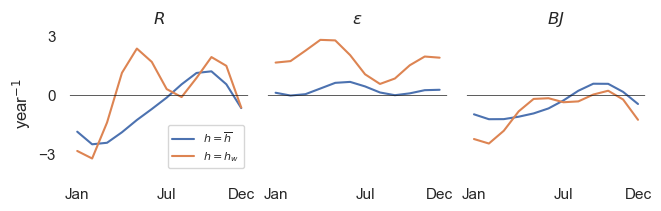

In [5]:
## colors for plotting
col = sns.color_palette()

## set up plot
fig, axs = plt.subplots(1, 3, figsize=(6.5, 2), layout="constrained")


## plot R and eps on LHS
axs[0].plot(p_h.cycle, p_h["R"], label=r"$h=\overline{h}$", c=col[0])
axs[0].plot(p_h.cycle, p_hw["R"], label=r"$h=h_w$", c=col[1])

axs[1].plot(p_h.cycle, p_h["epsilon"], c=col[0])
axs[1].plot(p_h.cycle, p_hw["epsilon"], c=col[1])

axs[2].plot(p_h.cycle, p_h["BJ_ac"])
axs[2].plot(p_hw.cycle, p_hw["BJ_ac"])

for ax in axs:
    ## format
    ax.axhline(0, ls="-", c="k", lw=0.5)
    ax.set_xticks([1, 7, 12], labels=["Jan", "Jul", "Dec"])
    ax.set_ylim([-4, 3.2])

## label
axs[1].set_yticks([])
axs[2].set_yticks([])
axs[0].set_yticks([-3, 0, 3])
axs[0].legend(prop=dict(size=8))
axs[0].set_ylabel("year$^{-1}$")
axs[0].set_title(r"$R$")
axs[1].set_title(r"$\varepsilon$")
axs[2].set_title(r"$BJ$")

plt.show()

## supplement
These are functions I used to compute indices

In [6]:
def get_nino34(data):
    """compute Niño 3.4 index from data"""

    ## get indexer
    idx = dict(latitude=slice(-5, 5), longitude=slice(190, 240))

    return spatial_avg(data.sel(idx))


def get_nino3(data):
    """compute Niño 3 index from data"""

    ## get indexer
    idx = dict(latitude=slice(-5, 5), longitude=slice(210, 270))

    return spatial_avg(data.sel(idx))


def get_RO_h(data):
    """compute RO's 'h' index from data"""

    ## get indexer
    idx = dict(latitude=slice(-5, 5), longitude=slice(120, 280))

    return spatial_avg(data.sel(idx))


def get_RO_hw(data):
    """compute RO's 'h' index from data"""

    ## get indexer
    idx = dict(latitude=slice(-5, 5), longitude=slice(120, 210))

    return spatial_avg(data.sel(idx))


def get_RO_indices(data, h_var="ssh"):
    """compute possible indices for RO from given dataset"""

    ## specify functions and variables
    funcs = [get_nino3, get_nino34, get_RO_h, get_RO_hw]
    vars_ = ["sst", "sst", h_var, h_var]
    names = ["T_3", "T_34", "h", "h_w"]

    ## compute indices
    indices = xr.merge([f(data[v]).rename(n) for f, v, n in zip(funcs, vars_, names)])

    return indices